# **Implementing Word2Vec with Logistic Regression and LSTM**

**CBOW (Continuous Bag-of-Words)** and **Skip-gram** are two popular algorithms used in natural language processing for generating word embeddings.

CBOW is a method that predicts the target word based on its context, which is a window of surrounding words. The goal of CBOW is to maximize the probability of predicting the target word given its context. In other words, CBOW learns to predict a word based on the words that surround it.

On the other hand, Skip-gram is the inverse of CBOW, where the algorithm predicts the context words given the target word. The goal of Skip-gram is to maximize the probability of predicting the context words given the target word.

The difference between CBOW and Skip-gram lies in their training objectives. CBOW is faster to train than Skip-gram because it involves predicting one target word from multiple context words, whereas Skip-gram predicts multiple context words from one target word. However, **Skip-gram is better at capturing rare and infrequent words, while CBOW is better at representing the overall meaning of a sentence**.

In summary, CBOW is a faster algorithm that predicts a target word based on its context. Hence we will be using CBOW in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, precision_recall_curve, average_precision_score, auc

from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec


In [4]:
#Read data from the first sheet
#This might take awhile...
path = '/content/gdrive/MyDrive/Colab Notebooks/DSA4263 Project/reviews.csv'
data = pd.read_csv(path)

In [5]:
data.head()

,date,partially_cleaned_text,sentiment,cleaned_text
0,18/6/21,This is a very healthy dog food. Good for thei...,1,healthy dog food good digestion also good smal...
1,7/7/21,I've been very pleased with the Natural Balanc...,1,pleased natural balance dog food dogs issues d...
2,18/6/21,"Before I was educated about feline nutrition, ...",1,educated feline nutrition allowed cats become ...
3,7/7/21,"My holistic vet recommended this, along with a...",1,holistic vet recommended along brands tried ca...
4,1/7/21,I bought this coffee because its much cheaper ...,1,bought coffee much cheaper ganocafe organic re...


Text(0.5, 1.0, 'Distribution of Sentiment Labels')

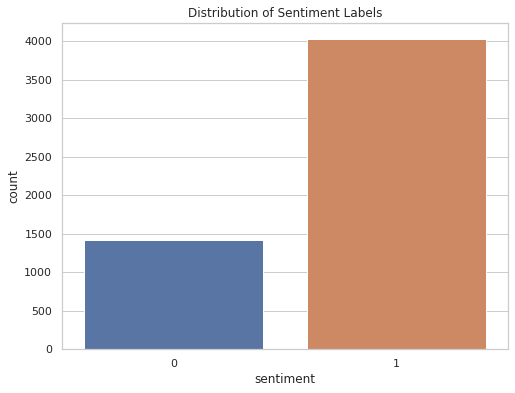

In [6]:
# plot Distribution of Sentiment Labels, checking of imbalanced data
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data = data, x = 'sentiment')
ax.set_title('Distribution of Sentiment Labels')

In [7]:
# tokenise the cleaned text
data['cleaned_text_new'] = data['cleaned_text'].apply(lambda x: word_tokenize(x))

## Word2Vec + Logistic Regression


In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text_new'], data['sentiment'] , test_size=0.2,  random_state=11)

In [9]:
# Train the CBOW architecture
w2v_model = gensim.models.Word2Vec(X_train, vector_size=100, window=5, min_count=2, sg =0)

In [10]:
# Represents all of the words that our Word2Vec model learned a vector for (i.e all of the words that appeared in the training data at least twice)

w2v_model.wv.index_to_key[0:20]

['like',
 'taste',
 'good',
 'great',
 'product',
 'would',
 'flavor',
 'one',
 'coffee',
 'love',
 'price',
 'really',
 'tea',
 'much',
 'get',
 'amazon',
 'food',
 'time',
 'buy',
 'even']

In [11]:
# find the most similar words based on word vectors from our trained model

w2v_model.wv.most_similar('coffee')

[('drink', 0.9958357810974121),
 ('tea', 0.9950664639472961),
 ('strong', 0.9938153624534607),
 ('cup', 0.9933298826217651),
 ('iced', 0.9932183623313904),
 ('flavor', 0.992867648601532),
 ('bitter', 0.9919336438179016),
 ('hot', 0.9914889931678772),
 ('like', 0.9911707043647766),
 ('chocolate', 0.9907476902008057)]

In [12]:
# Generate aggregated sentence vectors based on the word vectors (taken from trained w2v model) for each word in each row of review

# words that appear in the train w2v model
words = set(w2v_model.wv.index_to_key)

# train data
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
# test data
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

<ipython-input-12-7228ac135e42>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
<ipython-input-12-7228ac135e42>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])


In [13]:
# notice that length of the sentence different from the length of the sentence vector as some words may not appear in the w2v?
for i, v in enumerate(X_train_vect[:20]):
    print(len(X_train.iloc[i]), len(v))

38 37
14 13
12 12
15 15
31 29
18 17
38 37
14 14
31 27
47 47
19 19
38 38
32 30
29 29
94 88
21 21
17 17
40 40
23 23
12 11


In [14]:
# Maintain consistency in each sentence vector so that the size of our matrix is consistent
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        # take average weights across all the word vectors within the sentence vector
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        # else set zero vector of size 100 because the size of vector that we initially set is 100
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        # take average weights across all the word vectors within the sentence vector
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        # else set zero vector of size 100 because the size of vector that we initially set is 100
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [15]:
# now all sentence vector has consistent length of 100
for i, v in enumerate(X_train_vect_avg[:20]):
    print(len(X_train.iloc[i]), len(v))

38 100
14 100
12 100
15 100
31 100
18 100
38 100
14 100
31 100
47 100
19 100
38 100
32 100
29 100
94 100
21 100
17 100
40 100
23 100
12 100


In [16]:
X_train_vect_avg[0]

array([-0.26058054,  0.36760646,  0.20539394, -0.04783827,  0.08813808,
       -0.60959476,  0.19765328,  0.6665476 , -0.35277152, -0.22342208,
       -0.17544968, -0.47595716, -0.01676358,  0.1789007 ,  0.11047981,
       -0.24229467, -0.01449724, -0.5166511 ,  0.03000392, -0.7683334 ,
        0.24777858,  0.01669079,  0.17863762, -0.08151584, -0.13493885,
        0.00148607, -0.17653872, -0.21985196, -0.4295752 ,  0.08286061,
        0.31109828,  0.15058447,  0.05448637, -0.36130923, -0.14414799,
        0.35350293, -0.05816678, -0.37074894, -0.07870349, -0.7459498 ,
        0.04957513, -0.469295  , -0.23837543,  0.03989196,  0.34306923,
       -0.02881633, -0.31929862, -0.09354813,  0.22704071,  0.3535639 ,
        0.3486038 , -0.28185093, -0.14379263,  0.09200014, -0.2953661 ,
        0.15158556,  0.17072922,  0.0069647 , -0.43264514,  0.15302578,
        0.114422  ,  0.24795242, -0.13808247, -0.12970579, -0.3445673 ,
        0.27280205,  0.09481765,  0.14596738, -0.48774937,  0.42

In [17]:
print('Dimension of training data is {} by {}.'.format(len(X_train_vect_avg), len(X_train_vect_avg[0])))

Dimension of training data is 4355 by 100.


In [18]:
# format the response value
y_train.values.ravel()

array([1, 1, 1, ..., 0, 1, 0])

In [19]:
# Fit logistic regression
logr = LogisticRegression(random_state = 1)
logr.fit(X_train_vect_avg, y_train.values.ravel())

LogisticRegression(random_state=1)

In [20]:
# Use the trained model to make predictions on the val data
y_pred = logr.predict(X_test_vect_avg)

# accuracy metrics
print(classification_report(y_test, y_pred, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.78      0.02      0.05       294
           1       0.73      1.00      0.85       795

    accuracy                           0.73      1089
   macro avg       0.76      0.51      0.45      1089
weighted avg       0.75      0.73      0.63      1089



In [21]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_scores = f1_score(y_test, y_pred)
print('Val Precision: {} / Val Recall: {} / Val F1 Score: {} / Val Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(f1_scores, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Val Precision: 0.734 / Val Recall: 0.997 / Val F1 Score: 0.846 / Val Accuracy: 0.735


In [22]:
LR_y_pred = logr.predict_proba(X_test_vect_avg)
lr_y_test = y_test.copy()

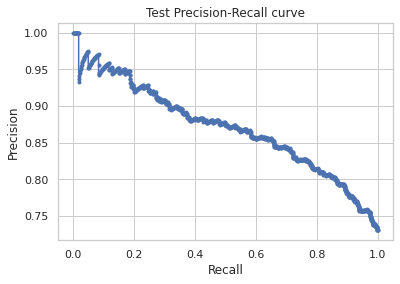

In [23]:
# keep probabilities for the positive outcome only
LR_y_probs = LR_y_pred[:, 1]

# plot the Test Precision-Recall curve
LR_precision, LR_recall, LR_thresholds = precision_recall_curve(lr_y_test, LR_y_probs)

plt.plot(LR_recall, LR_precision,  marker='.', label = "LogReg")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Test Precision-Recall curve");

In [24]:
auc(LR_recall, LR_precision)

0.8707857001952749

In [27]:
average_precision_score(y_test, LR_y_probs)

0.8709638529458524